In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# neural network packages
import torch
import torch.utils
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
torch.manual_seed(0)

# data processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split

# to estimate the HAR model
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# own helping code
from utils.estimating import model_estimator, EarlyStopper
from utils.preprocessing import PreProcessor, data_to_loaders
from utils.functions import get_ticker_daily_close, print_nicely, reset_model_weights

# ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

### Process Data to Features, Targets and Divide in Training/Validation Data

In [14]:
# LOAD DATA
# file_name = "msft_stock.csv"
# data = pd.read_csv("data/" + file_name)
# returns = data["price"].apply(np.log).diff()

# or through yahoo finance
prices = get_ticker_daily_close("KO")
returns = prices.apply(np.log).diff()
print(f"Total observations: {len(returns)}")

################################################################
# targets are just the squared returns
targets = returns ** 2

# features for neural network (lagged input)
df = pd.DataFrame({})
lags = 20
for i in range(1, lags+1):
    df[f"lag_{i}"] = targets.shift(i)

# features for HAR (realized daily/weekly/monthly volatility)
features_har = np.zeros(shape=(len(targets), 3))
features_har[:, 0] = targets.shift(1).values
features_har[:, 1] = targets.rolling(5).apply(np.mean).shift(1).values
features_har[:, 2] = targets.rolling(21).apply(np.mean).shift(1).values

df_har = pd.DataFrame({})
df_har["rv_d"] = targets.shift(1)
df_har["rv_w"] = targets.rolling(5).apply(np.mean)
df_har["rv_m"] = targets.rolling(21).apply(np.mean)
    
# features and targets to numpy array
features_har = df_har.values
features = df.values
targets = targets.values.reshape(-1,1)

# this way we use the exact same features in the NN as in the HAR model
# can be changed ofcourse
features = features_har.copy()

# add constant for har features and drop nan values
features_har = sm.add_constant(features_har)

start_index, end_index = 21, -1
features_har = features_har[start_index:end_index]
features = features[start_index:end_index]
targets = targets[start_index:end_index]

# final overview if features and targets
print(f"shape har featurs: {features_har.shape} of type {type(features_har)}")
print(f"shape nn features: {features.shape} of type {type(features)}")
print(f"shape targets: {targets.shape} of type {type(targets)}")

# split the data into the features set (used for cross validation and ultimately estimating the final model) and testing data
train_size = .8
features_har, features_har_validation, _placeholder, targets_validation = train_test_split(features_har, targets, shuffle=False, train_size = train_size)
features, features_validation, targets, targets_validation = train_test_split(features, targets, shuffle=False, train_size = train_size)


# In the end we have features, features_har and targets.
# These are used for determining the Neural Network specification through cross validation.
# If this is determined, the NN is estimated on features, targets and HAR on features_har, targets.
# THEN both predict targets_validation on features_validation and features_har_validation

Total observations: 15365
shape har featurs: (15343, 4) of type <class 'numpy.ndarray'>
shape nn features: (15343, 3) of type <class 'numpy.ndarray'>
shape targets: (15343, 1) of type <class 'numpy.ndarray'>


### Define Neural Network
Here 2 neural networks are defined. The last one is now used in the estimation further on. A Recurrent neural network might be interesting to try out as well, due to its usually good performance on time series

In [15]:
class RecurrentNeuralNetwork(nn.Module):
    """ This class holds our model with 2 layers """
    def __init__(self, lags, hidden_dim = 1, n_layers = 1, output_size = 1):
        # initialize nn.Module
        super(RecurrentNeuralNetwork, self).__init__()
        
        # store model specifications
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # initialize layers
        self.rn = nn.RNN(lags, hidden_dim, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x: torch.Tensor):
        """ feed forward a given input through 2 layers """
        x = x.unsqueeze(0)
        batch_size = x.size(0)
        
        hidden = self.init_hidden(batch_size)
        x, hidden = self.rn(x, hidden)
        x = x.contiguous().view(-1, self.hidden_dim)
        
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        
class RegularNN(nn.Module):
    """ This class holds our model with 2 layers """
    def __init__(self, input_size, hidden_nodes: int = 10, output_size = 1):
        # initialize nn.Module
        torch.manual_seed(3407)
        super().__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_nodes, bias = True)
        self.fc2 = nn.Linear(hidden_nodes, output_size, bias = True)

    def forward(self, x: torch.Tensor):
        """ feed forward a given input through 2 layers """             
        x = torch.flatten(x,1)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

### Compare Neural Network VS HAR
A list of model specification can be given here.
There is a certain number of kfolds stepping through time (this is a must for time series cross validation).
The models are estimated on exactly the same data and for both the out of sample accuracy is computed.
The HAR model is estimated through regular OLS: Vol (1 day ahead) = constant + fac1 * Vol (1d) + fac2 * Vol (5d) + fac3 * Vol(20d)
The NN is estimated using Adam optimzer and MSE loss, with a specified learning rate.

In [32]:
def fit_and_evaluate_model_by_kfolds(hidden_nodes, lr, epochs):
    # initialise model with provided specification
    model = RegularNN(input_size = features.shape[1], hidden_nodes = hidden_nodes, output_size = targets.shape[1])
    kfold = TimeSeriesSplit(n_splits = 4, max_train_size = 7000, test_size = 500)
    score_nn = []
    
    i = 0
    for train_index, test_index in kfold.split(features):
        # reset weights to start estimating from exactly the same initialization for each fold
        reset_model_weights(model)

        # split data into feature and target data for neural network
        features_train, features_test, targets_train, targets_test = features[train_index], features[test_index], targets[train_index], targets[test_index]
        features_train_har, features_test_har = features_har[train_index], features_har[test_index]
        
        # fit normalizer on train features and normalize data
        scaler = StandardScaler()
        features_train = scaler.fit_transform(features_train)
        features_test = scaler.transform(features_test)

        # all features and targets to float tensor
        features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
        features_test_tensor = torch.tensor(features_test, dtype=torch.float32)
        targets_train_tensor = torch.tensor(targets_train, dtype=torch.float32)
        targets_test_tensor = torch.tensor(targets_test, dtype=torch.float32)
        
        # feature/target tensors to dataloaders
        trainloader, testloader = data_to_loaders(features_train_tensor, features_test_tensor, targets_train_tensor, targets_test_tensor)
                
        # initialize and estimate the model
        criterion = nn.MSELoss()
        
        model_estimator(
            model,
            optimizer = optim.Adam(model.parameters(), lr = lr), 
            criterion = criterion, 
            epochs=epochs,
            trainloader=trainloader, 
            testloader=testloader,
            earlystopper=EarlyStopper(patience = 3, min_delta = 0))
        
        # perform out of sample prediction
        output = model(features_test_tensor)
        loss = criterion(output, targets_test_tensor)
        
        score_nn += [loss.item()]
    return np.mean(score_nn)

In [24]:
# PERFORM CROSS VALIDATION
plot = False
avg_scores = []
model_scores = []

for hidden_nodes in [2, 4, 7]:
    for lr in [0.0005, 0.001, 0.005, 0.01]:
        for epochs in [6]:
    
            print(f"Model Specification: \nnodes: {hidden_nodes} lr: {lr} epochs: {epochs}")
            
            # initialize model and kfolds
            kfold = TimeSeriesSplit(n_splits = 10, max_train_size = 5000)
            model = RegularNN(input_size = features.shape[1], hidden_nodes = hidden_nodes, output_size = targets.shape[1])
            
            score_nn = []

            i = 0
            for train_index, test_index in kfold.split(features):
                # print(train_index, test_index)
                
                i += 1
                
                # reset model params
                reset_model_weights(model)
                
                # split data into feature and target data for neural network
                features_train, features_test, targets_train, targets_test = features[train_index], features[test_index], targets[train_index], targets[test_index]
                features_train_har, features_test_har = features_har[train_index], features_har[test_index]
                
                # fit normalizer on train features and normalize data
                scaler = StandardScaler()
                features_train = scaler.fit_transform(features_train)
                features_test = scaler.transform(features_test)

                # all features and targets to float tensor
                features_train_tensor = torch.tensor(features_train, dtype=torch.float32)
                features_test_tensor = torch.tensor(features_test, dtype=torch.float32)
                targets_train_tensor = torch.tensor(targets_train, dtype=torch.float32)
                targets_test_tensor = torch.tensor(targets_test, dtype=torch.float32)
                
                # feature/target tensors to dataloaders
                trainloader, testloader = data_to_loaders(features_train_tensor, features_test_tensor, targets_train_tensor, targets_test_tensor)
                        
                # initialize and estimate the model
                criterion = nn.MSELoss()
                
                model_estimator(
                    model,
                    optimizer = optim.Adam(model.parameters(), lr = lr), 
                    criterion = criterion, 
                    epochs=epochs,
                    trainloader=trainloader, 
                    testloader=testloader,
                    earlystopper=EarlyStopper(patience = 3, min_delta = 0))
                
                # perform out of sample prediction
                output = model(features_test_tensor)
                loss = criterion(output, targets_test_tensor)
                
                score_nn += [loss.item()]

            avg_score_nn = np.average(score_nn)
            avg_scores += [avg_score_nn]
            print(f"Average NN MSE Loss: {avg_score_nn}")
            
            # model_scores += ["epochs": epochs, "hidden_nodes": hidden_nodes, "lr": lr})]
            model_scores += [(avg_score_nn, epochs, hidden_nodes, lr)]

# store the score with hyperparams in a dataframe, sort on lowest MSE and show
df_scores = pd.DataFrame(data = model_scores, columns = ["avg_score", "epochs", "hidden_nodes", "lr"])
df_scores = df_scores.sort_values(by="avg_score", ascending = True).reset_index(drop=True)
df_scores

Model Specification: 
nodes: 2 lr: 0.0005 epochs: 6
Average NN MSE Loss: 0.000825078122920786
Model Specification: 
nodes: 2 lr: 0.001 epochs: 6
Average NN MSE Loss: 0.0001606870035857355
Model Specification: 
nodes: 2 lr: 0.005 epochs: 6
Early stopping due to no decrease in validation loss at epoch: 6
Early stopping due to no decrease in validation loss at epoch: 5
Average NN MSE Loss: 1.534378646894652e-05
Model Specification: 
nodes: 2 lr: 0.01 epochs: 6
Early stopping due to no decrease in validation loss at epoch: 6
Early stopping due to no decrease in validation loss at epoch: 6
Early stopping due to no decrease in validation loss at epoch: 4
Early stopping due to no decrease in validation loss at epoch: 6
Average NN MSE Loss: 9.271982280267821e-06
Model Specification: 
nodes: 4 lr: 0.0005 epochs: 6
Average NN MSE Loss: 0.005958971873405971
Model Specification: 
nodes: 4 lr: 0.001 epochs: 6
Average NN MSE Loss: 0.00039517848672403487
Model Specification: 
nodes: 4 lr: 0.005 epoch

,index,avg_score,epochs,hidden_nodes,lr
0,3,0.000009,6,2,0.0100
1,10,0.000012,6,7,0.0050
2,2,0.000015,6,2,0.0050
3,11,0.000026,6,7,0.0100
4,7,0.000027,6,4,0.0100
5,6,0.000047,6,4,0.0050
6,1,0.000161,6,2,0.0010
7,9,0.000381,6,7,0.0010
8,5,0.000395,6,4,0.0010
9,0,0.000825,6,2,0.0005


### Fit and Compare the Final Models

=================================Estimating HAR and NN for fold: 10=================================
Normalizing features ...
Estimating HAR model ...


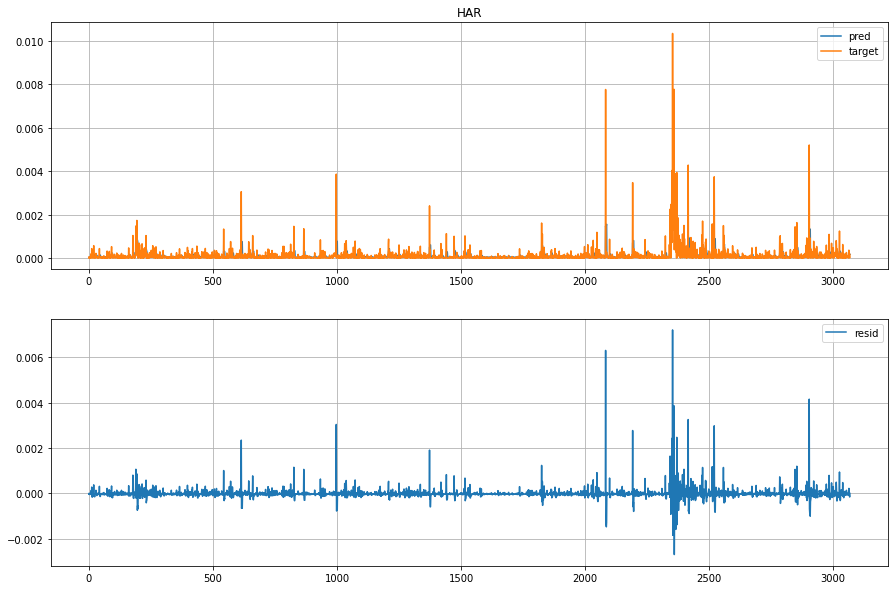

HAR out-of-sample loss: 2.4838511908233874e-07
Estimating NN model ...
NN out-of-sample loss: 1.7498031468221598e-07


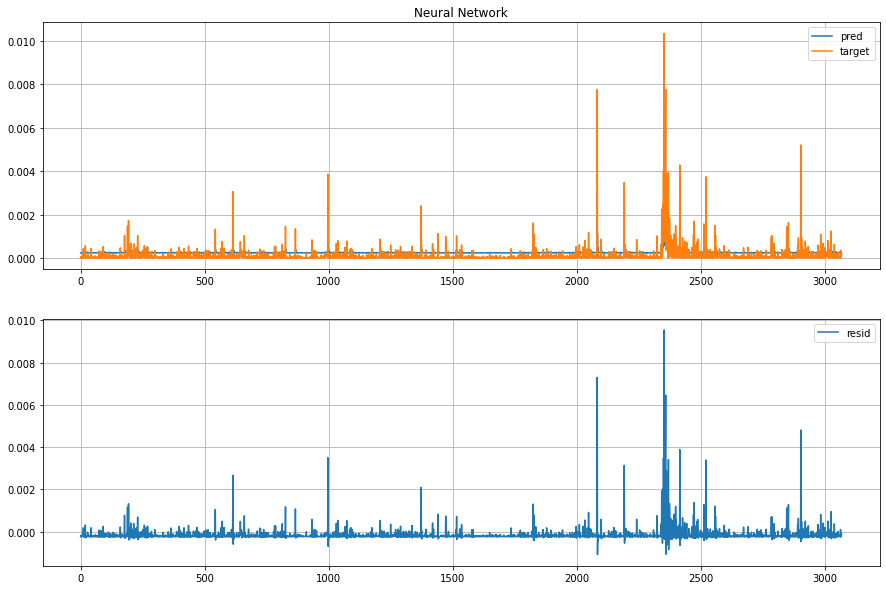

In [31]:
plot = True

# these params are taken from the extensive cross validations performed above
epochs = 4
hidden_nodes = 5
lr = 0.01

note = f"Estimating HAR and NN for fold: {i}"
print_nicely(note, 100)

# the available features
features_har, features, targets
features_har_validation, features_validation ,targets_validation

# fit normalizer on train features and normalize data
print("Normalizing features ...")
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

#=========================================================================================
#===================================ESTIMATE HAR==========================================
#=========================================================================================
print("Estimating HAR model ...")
mod = OLS(targets, features_har, hasconst = True)
mod = mod.fit()
output = mod.predict(features_har_validation)

loss = np.var(targets_validation - output)
score_har = loss

if plot:        
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15, 10))
    axs[0].set_title("HAR")
    axs[0].plot(output, label = "pred")
    axs[0].plot(targets_validation, label = "target")
    axs[1].plot(targets_validation.reshape(-1,) - output, label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

print(f"HAR out-of-sample loss: {loss}")

#=========================================================================================
#====================================ESTIMATE NN==========================================
#=========================================================================================

# all features and targets to float tensor
features_train_tensor = torch.tensor(features, dtype=torch.float32)
features_test_tensor = torch.tensor(features_validation, dtype=torch.float32)
targets_train_tensor = torch.tensor(targets, dtype=torch.float32)
targets_test_tensor = torch.tensor(targets_validation, dtype=torch.float32)

trainloader, testloader = data_to_loaders(features_train_tensor, features_test_tensor, targets_train_tensor, targets_test_tensor)
        
# initialize and estimate the model
print("Estimating NN model ...")
model = RegularNN(features.shape[1], hidden_nodes, targets.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
epochs = epochs

model_estimator(
    model,
    optimizer, 
    criterion, 
    epochs=epochs,
    trainloader=trainloader, 
    testloader=testloader,
    earlystopper=None)

# perform out of sample prediction
output = model(features_test_tensor)
loss = criterion(output, targets_test_tensor)
score_nn = loss.item()

print(f"NN out-of-sample loss: {loss}")

if plot:
    # plot prediction versus true daily volatility
    fig, axs = plt.subplots(2,1, figsize = (15,10))
    axs[0].set_title("Neural Network")
    axs[0].plot(output.detach().numpy(), label = "pred")
    axs[0].plot(targets_test_tensor.detach().numpy(), label = "target")
    axs[1].plot(targets_test_tensor.detach().numpy() - output.detach().numpy(), label = "resid")
     
    for ax in axs:
        ax.legend()
        ax.grid()
    plt.show()

#=========================================================================================
#=========================================================================================
#=========================================================================================